In [11]:
from carbon.helpers.stdimports import *
from carbon.helpers.pdread import *
from carbon.helpers.strategy import *
from carbon.helpers.fls import *

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [12,6]

# Carbon Simulation - Demo 7-3 (frozen data)

## Setup

### Path data
filename determines collection, eg `RANPTH-05000-0000` is sig=50% vol and mu=0% drift; see available collections in the `ls` command below

In [12]:
DATAID = "RANPTH-05000-0000"

DATAPATH = "../data"
DATAFN = j(DATAPATH, f"{DATAID}.pickle")
print(f"Chose data id {DATAID}")

Chose data id RANPTH-05000-0000


In [13]:
!ls {DATAPATH}/*.pickle

../data/RANPTH-00500-0000.pickle ../data/RANPTH-05000-0000.pickle
../data/RANPTH-01000-0000.pickle ../data/RANPTH-07500-0000.pickle
../data/RANPTH-02000-0000.pickle ../data/RANPTH-10000-0000.pickle


### Generated output

If `OUTPATH` is `None`, output will not be saved, otherwise it will be saved to the indicated directory (use `"."` for current)

In [14]:
OUTPATH = "/Users/skl/Desktop/sim7-3"       # uncomment to save charts in specific location
OUTPATH = "."                               # uncomment to save charts in current directory
OUTPATH = None                              # uncomment to not save charts
if OUTPATH and OUTPATH != ".":
    !mkdir {OUTPATH}
    !rm {OUTPATH}/*.png
print(f"OUTPATH = {OUTPATH}")

OUTPATH = None


### Strategies

This is the list of strategies to be tested against the paths. The 

In [15]:
strats = (
    strategy.from_mwh(m=100, g=0.10, w=0.05, amt_rsk=1, amt_csh=0),
    strategy.from_mwh(m=100, g=0.20, w=0.05, amt_rsk=1, amt_csh=0),
    strategy.from_mwh(m=100, g=0.10, w=0.20, amt_rsk=1, amt_csh=0),
    strategy.from_mwh(m=100, g=0.20, w=0.20, amt_rsk=1, amt_csh=0),
)
#strats

## Simulation code

In [16]:
def run_sim(strat, path):
    Sim = CarbonSimulatorUI(pair=strat.slashpair)
    Sim.add_strategy(*strat.p)
    #print(strat.p)

    ouis = Sim.state()["orderuis"]
    rskamt_r  = [ouis[0].y]
    cshamt_r = [ouis[1].y]
    for spot in path[1:]:
        #print(spot)
        for oui in ouis.values():
            oui.tradeto(spot)
        rskamt_r  += [ouis[0].y]
        cshamt_r += [ouis[1].y]
    
    value_r = rskamt_r * path + cshamt_r
    return rskamt_r, cshamt_r, value_r 

In [17]:
def plot_sim(strat, rskamt_f, cshamt_r, value_r, dataid):
    rskamt_f  = rskamt_r[-1]
    cshamt_f  = cshamt_r[-1]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    plots = []
    plots += ax1.plot(path, color="0.7", label="price")
    plots += [ax1.fill_between(path.index, strat.p_buy_a, strat.p_buy_b, color="lightgreen", alpha=0.1, label="bid range")]
    plots += [ax1.fill_between(path.index, strat.p_sell_a, strat.p_sell_b, color="lightcoral", alpha=0.1, label="ask range")]
    plots += ax2.plot(value_r, color = "blue", label="value [rhs]")
    ax2.set_ylabel("portfolio value (USDC)")
    ax1.set_ylabel("price")
    ax1.set_xlabel("date")
    plt.title(f"{strat.descr} on {dataid}")
    labels = [p.get_label() for p in plots]
    plt.legend(plots, labels)
    #print(f"t={   0:3.1f}: {rskamt_r[ 0]:5.1f} ETH {cshamt_r[ 0]:8.1f} USDC (value = {value_r[ 0]:6.1f} USDC)")
    #print(f"t={time:3.1f}: {rskamt_r[-1]:5.1f} ETH {cshamt_r[-1]:8.1f} USDC (value = {value_r[-1]:6.1f} USDC)")

## Simulation run

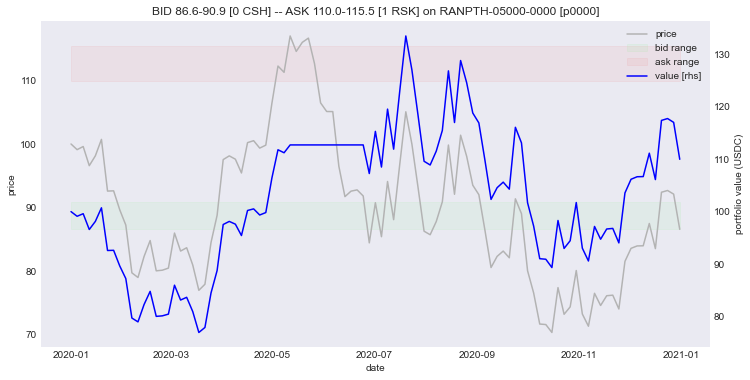

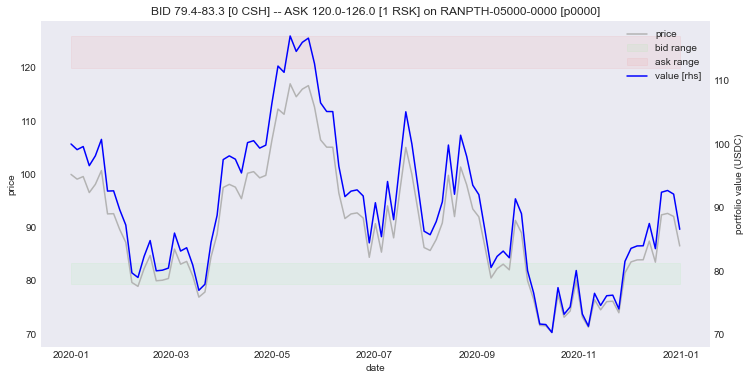

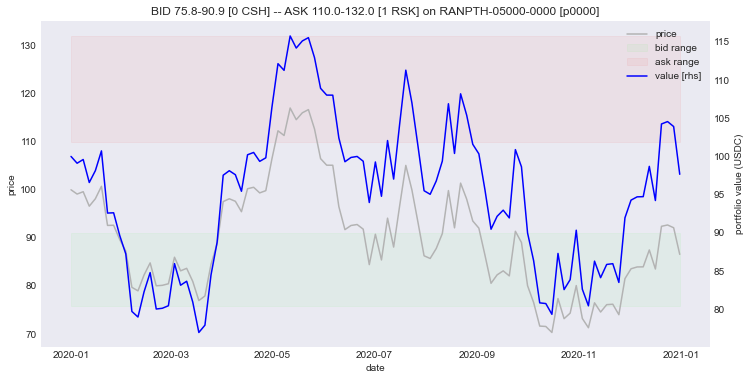

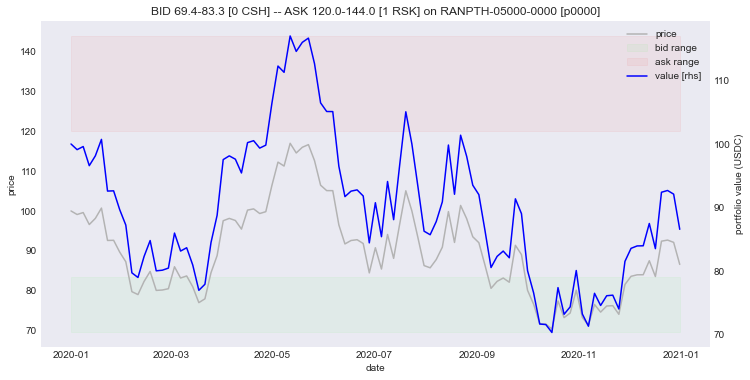

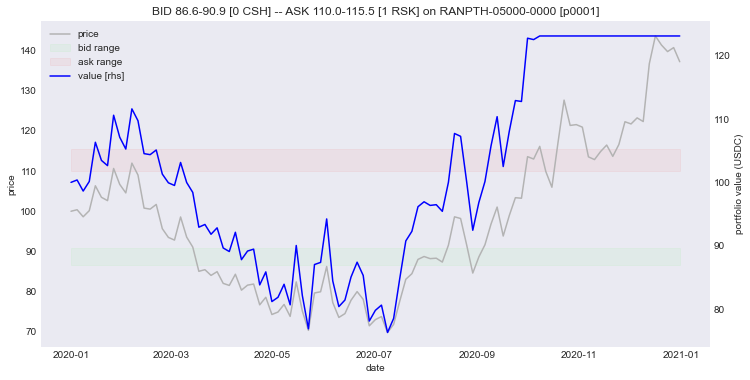

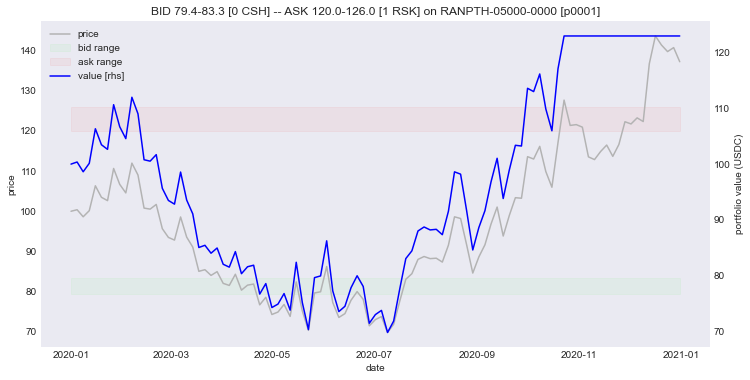

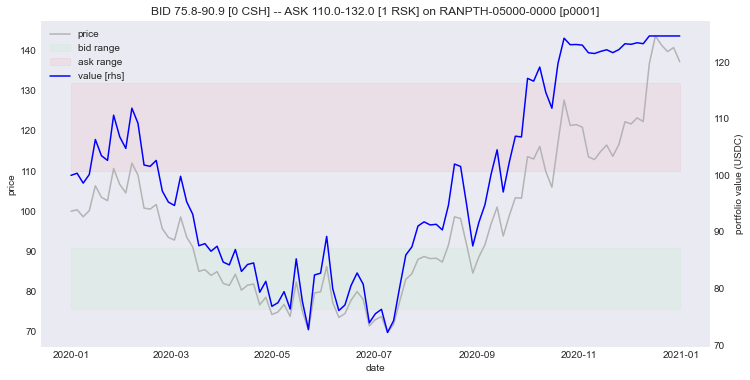

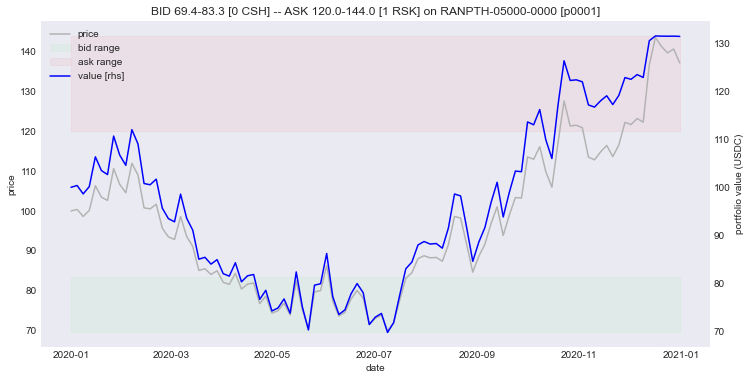

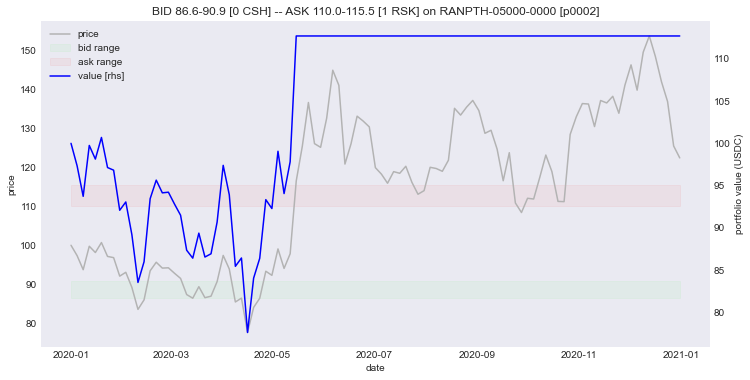

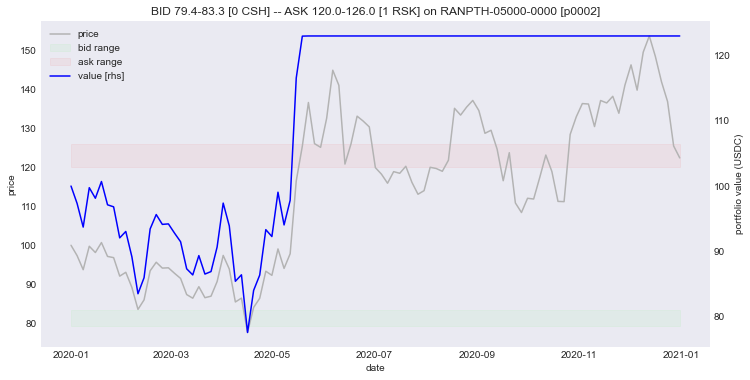

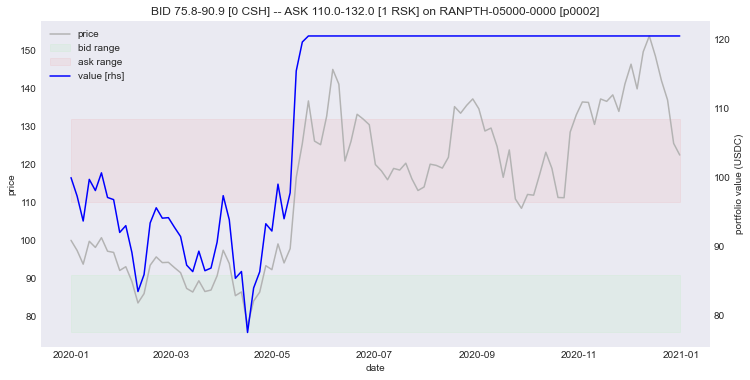

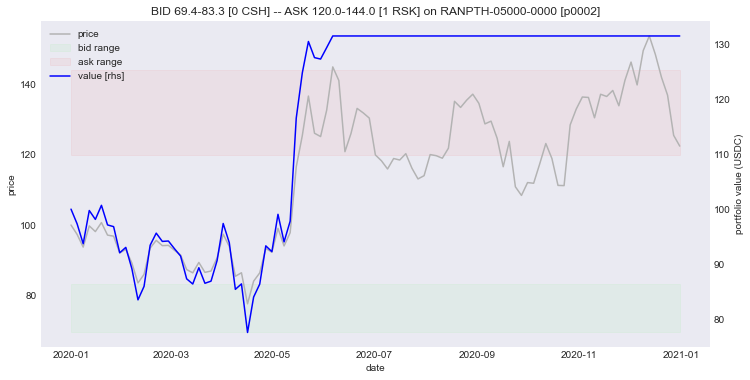

In [18]:
for colnm in ["p0000", "p0001", "p0002"]:
    for ix, strat in enumerate(strats):
    
        path = pdread(DATAFN, colnm)
        time = pathtime(path)

        rskamt_r, cshamt_r, value_r = run_sim(strat, path)
        plot_sim(strat, rskamt_r, cshamt_r, value_r, f"{DATAID} [{colnm}]")
        
        # save charts
        if isinstance(OUTPATH, str):
            ffn = j(OUTPATH, f"{DATAID}-{colnm}-{ix}.png")
            print(f"Saving figure {ffn}")
            plt.savefig(ffn)
        plt.show()

In [19]:
if OUTPATH:
    !ls {OUTPATH}/*.png

In [20]:
if OUTPATH and OUTPATH != ".":
    filelist = os.listdir(OUTPATH)
    filelist = [fn for fn in filelist if fn[-4:]==".png"]
    markdown = "\n\n".join(f"![]({OUTPATH}/{fn})" for fn in filelist)
    fsave(markdown, "_sim-charts.md", OUTPATH)
    !pandoc {OUTPATH}/_sim-charts.md -o {OUTPATH}/_sim-charts.docx